In [139]:
import os
import sys
from copy import deepcopy
import seaborn as sns
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import torch
import pandas as pd
sns.set(style='white', rc={
    'figure.figsize':(12,8),
    'legend.fontsize': 'large',
    'legend.title_fontsize': 'large',
    'axes.labelsize': 'large',
    'axes.titlesize':'large',
    'xtick.labelsize':'large',
    'ytick.labelsize':'large',
    'font.family': 'sans-serif',
    'font.sans-serif': 'Lucida Grande'
})

from simulated_utils import compare
from simulated_utils import BanditEnv

def filter_df(df, **kwargs):
    for k,v in kwargs.items():
        df = df[df[k] == v]
    return df

In [38]:
from scipy.stats import norm

In [2]:
import pickle
with open('single_small_peak_1d_gaussian.pkl', 'rb') as f:
    data = pickle.load(f)

In [210]:
import pickle
with open('single_small_peak_1d_beta.pkl', 'rb') as f:
    data_beta = pickle.load(f)

In [3]:
data

,iter,loss,mean_reward,pd_param_0_mean,pd_param_1_mean,method,mean,std
0,0.0,-0.027527,0.044713,0.000000,1.000000,Clipping,0.000000,1.000000
1,1.0,-0.058452,0.078428,-0.186414,0.913123,Clipping,-0.186414,0.913123
2,2.0,-0.024068,0.081487,-0.348298,0.870037,Clipping,-0.348298,0.870037
3,3.0,-0.076156,0.116762,-0.559323,0.717232,Clipping,-0.559323,0.717232
4,4.0,-0.039063,0.090818,-0.728281,0.616031,Clipping,-0.728281,0.616031
...,...,...,...,...,...,...,...,...
95,95.0,0.006436,-0.001417,-2.699755,0.220888,Clipping,-2.699755,0.220888
96,96.0,0.008644,0.003660,-2.758118,0.238851,Clipping,-2.758118,0.238851
97,97.0,0.003858,-0.001897,-2.736190,0.249402,Clipping,-2.736190,0.249402
98,98.0,0.057267,0.003750,-2.737217,0.239248,Clipping,-2.737217,0.239248


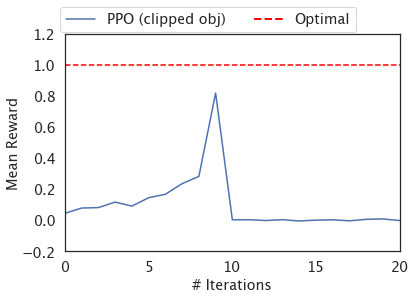

In [153]:
niters = 20
fig, axes = plt.subplots(1, 1, figsize=(6, 4), sharex=True)
sns.lineplot(data=data_gaussian, x='iter', y='mean_reward', hue='method', ax=axes, n_boot=n_boot)
axes.set_ylabel('Mean Reward', labelpad=0)
axes.set_xlim([0, niters])
axes.set_ylim([-0.2, 1.2])
axes.set_xlabel('# Iterations')
from matplotlib.lines import Line2D
axes.hlines(1.0, 0, 20, colors='red', linestyles='dashed')
redline = Line2D([0], [0], color='red', ls='dashed', lw=2)
#blueine = Line2D([0], [0], color='darkblue', lw=1)
handles, labels = axes.get_legend_handles_labels()
handles=[handles[1], redline]
labels=['PPO (clipped obj)','Optimal']
axes.get_legend().remove()
fig.legend(handles, labels, ncol=2, loc='upper center')
plt.show()

In [169]:
def reward_scalar(x, double_peaks=False):
    if double_peaks and x > 0.5 and x < 2:
        return 0.5
    if x > -1.0 and x < -0.8:
        return 1.0
    return 0.0

reward = np.vectorize(reward_scalar)

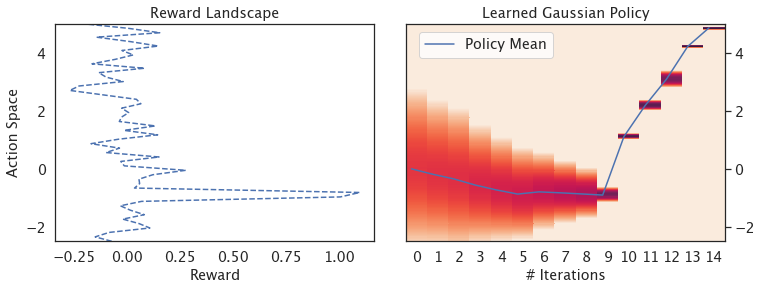

In [209]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=False)
y1 = -2.5
y2 = 5
niters = 15
nbins = 201
x = np.linspace(y1, y2, 50)
axes[0].set_ylim([y1, y2])
axes[0].set_ylabel('Action Space')
axes[0].set_title('Reward Landscape')
axes[0].set_xlabel('Reward')
axes[0].plot(reward(x) + 0.1 * np.random.randn(x.shape[0]), x,
             linestyle='--', label='Reward function', alpha=1)
axes[1].set_ylim([y1, y2])
ax1_twin = axes[1].twinx()
ax1_twin.set_ylim([y1, y2])
x = np.linspace(y1, y2, nbins)
binwidth = (x[1]-x[0])
heatmap = np.zeros((niters, nbins))
for i in range(niters):
    mean = data_gaussian[data_gaussian.iter == i]['mean'].values.item()
    std = data_gaussian[data_gaussian.iter == i]['std'].values.item()
    rv = norm(loc=mean, scale=std)
    heatmap[i, :] = np.log(1e-6 + rv.cdf(x + binwidth/2) - rv.cdf(x - binwidth/2))
#yticklabels = [xx.round(2) if i % 5 == 0 else ''  for i, xx in enumerate(x)]
sns.heatmap(np.flip(heatmap.T, axis=0), ax=axes[1], square=False, cmap=sns.cm.rocket_r, vmin=-8, vmax=1.0,
            cbar=False, annot=False)
ax1_twin.plot(data_gaussian[data_gaussian.iter < niters].iter + 0.25,
              data_gaussian[data_gaussian.iter < niters]['mean'], label='Policy Mean')
#ax1_twin.hlines(2.5, 0, 20, color='black')
axes[1].get_yaxis().set_ticks([])
axes[1].set_title('Learned Gaussian Policy')
axes[1].set_xlabel('# Iterations')


fig.align_ylabels(axes)
fig.subplots_adjust(wspace=0.1)
handles, labels = ax1_twin.get_legend_handles_labels()
fig.legend(handles, labels, loc=(0.55, 0.8), ncol=3)
plt.show()

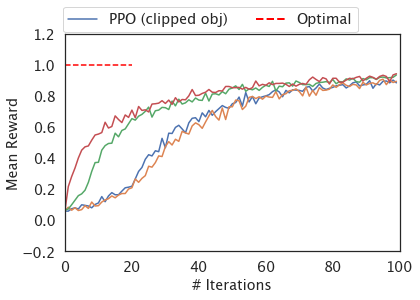

In [212]:
niters = 100
fig, axes = plt.subplots(1, 1, figsize=(6, 4), sharex=True)
sns.lineplot(data=data_beta, x='iter', y='mean_reward', hue='method', ax=axes, n_boot=n_boot)
axes.set_ylabel('Mean Reward', labelpad=0)
axes.set_xlim([0, niters])
axes.set_ylim([-0.2, 1.2])
axes.set_xlabel('# Iterations')
from matplotlib.lines import Line2D
axes.hlines(1.0, 0, 20, colors='red', linestyles='dashed')
redline = Line2D([0], [0], color='red', ls='dashed', lw=2)
#blueine = Line2D([0], [0], color='darkblue', lw=1)
handles, labels = axes.get_legend_handles_labels()
handles=[handles[1], redline]
labels=['PPO (clipped obj)','Optimal']
axes.get_legend().remove()
fig.legend(handles, labels, ncol=2, loc='upper center')
plt.show()

/home/eecs/chloehsu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


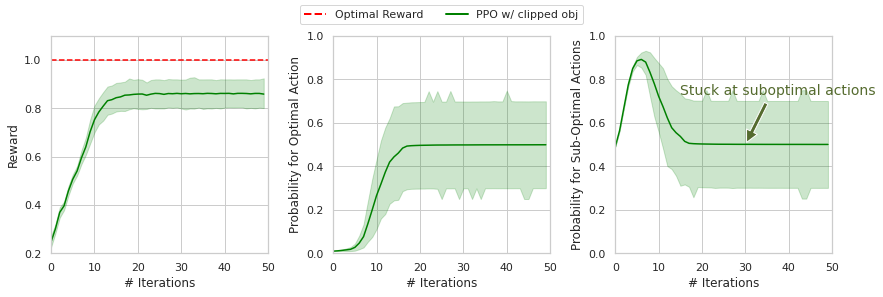

In [251]:
fig, ax = plt.subplots(1, 3, figsize=(14, 4))
sns.lineplot(data=clip_data, x='iter', y='mean_reward', ax=ax[0],
             hue='method', palette=['green'], legend=False)
ax[0].set_ylabel('Reward')
sns.lineplot(data=clip_data, x='iter', y='pd_param_0_mean', ax=ax[1],
             hue='method', palette=['green'], legend=False)
ax[1].set_ylabel('Probability for Optimal Action')
clip_data['subopt_prob'] = clip_data[[f'pd_param_{i}_mean' for i in range(1,50)]].sum(axis=1)
sns.lineplot(data=clip_data, x='iter', y='subopt_prob', ax=ax[2],
             hue='method', palette=['green'], legend=False)
ax[2].set_ylabel('Probability for Sub-Optimal Actions')
for a in ax:
    a.set_xlabel('# Iterations')
    a.set_ylim([0,1])
    a.set_xlim([0,50])
ax[0].set_ylim([0.2, 1.1])
fig.subplots_adjust(wspace=0.3)

from matplotlib.lines import Line2D
ax[0].hlines(1.0, 0, 50, colors='red', linestyles='dashed')
blackline = Line2D([0], [0], color='red', ls='dashed', lw=2, label='Optimal Reward')
greenline = Line2D([0], [0], color='green', ls='solid', lw=2, label='PPO w/ clipped obj')
fig.legend(handles=[blackline, greenline], loc='upper center', ncol=2)


ax[2].text(15, 0.75, "Stuck at suboptimal actions", ha="left", va="center", size=14, color='darkolivegreen')
ax[2].annotate('', xy=(30, 0.5),  xycoords='data',
            xytext=(0.7, 0.7), textcoords='axes fraction',
            arrowprops=dict(facecolor='darkolivegreen', shrink=0.05),
            horizontalalignment='right', verticalalignment='top',
            )


plt.show()

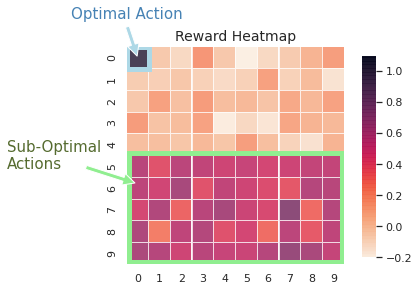

In [233]:
fig, ax = plt.subplots(1,1, figsize=(4,4))
rewards = np.random.randn(10,10) * 0.1
rewards[5:, :] += 0.5
rewards[0,0] = 1.0
cbar_ax = fig.add_axes([.95, .15, .05, .7])
ax.set_title('Reward Heatmap', fontsize=14)
sns.heatmap(rewards, ax=ax, square=True, cmap=sns.cm.rocket_r, linewidths=.1, vmin=-0.2, vmax=1.1, cbar_ax=cbar_ax, alpha=0.8)
from matplotlib import patches
rect = patches.Rectangle((0,0),1,1,linewidth=5,edgecolor='lightblue',facecolor='none')
ax.add_patch(rect)
ax.text(0, -1.5, "Optimal Action", ha="center", va="center", size=15, color='steelblue')
ax.annotate('', xy=(0.5, 0.5),  xycoords='data',
            xytext=(0, 1.1), textcoords='axes fraction',
            arrowprops=dict(facecolor='lightblue', shrink=0.05),
            horizontalalignment='right', verticalalignment='top',
            )

rect = patches.Rectangle((0.1,4.89),9.8,5,linewidth=5,edgecolor='lightgreen',facecolor='none')
ax.text(-5.5, 5, "Sub-Optimal\nActions", ha="left", va="center", size=15, color='darkolivegreen')
ax.annotate('', xy=(0.5, 6.3),  xycoords='data',
            xytext=(-0.2, 0.45), textcoords='axes fraction',
            arrowprops=dict(facecolor='lightgreen', shrink=0.05),
            horizontalalignment='right', verticalalignment='top',
            )

ax.add_patch(rect)
plt.show()

In [225]:
with open('discrete_100actions_stats.pkl', 'rb') as f:
    stats_combined = pickle.load(f)

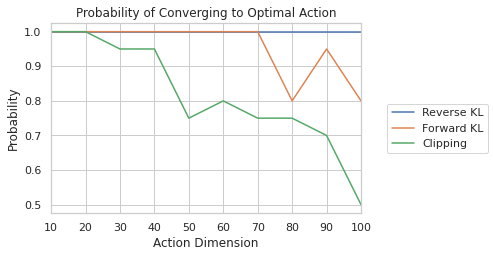

In [232]:
fig, ax = plt.subplots(1, 1, figsize=(7, 3.5))
fig.subplots_adjust(right=0.74)
sns.lineplot(data=stats_combined.reset_index(), x='action_dim', y='converge', hue='method', markers=['x'], ax=ax)
plt.xlabel('Action Dimension')
plt.ylabel('Probability')
handles, labels = ax.get_legend_handles_labels()
ax.get_legend().remove()
ax.set_xlim([10,100])
fig.legend(handles[1:], labels[1:], loc='center right', ncol=1)
plt.title('Probability of Converging to Optimal Action')
plt.show()

In [101]:
filter_df(clip_data, iter=plot_every * i).mean(axis=0)

iter                6.000000
loss               -0.125878
mean_reward         0.540726
pd_param_0_mean     0.046768
pd_param_10_mean    0.003282
                      ...   
pd_param_96_mean    0.001198
pd_param_97_mean    0.001267
pd_param_98_mean    0.001276
pd_param_99_mean    0.001178
pd_param_9_mean     0.047437
Length: 103, dtype: float64

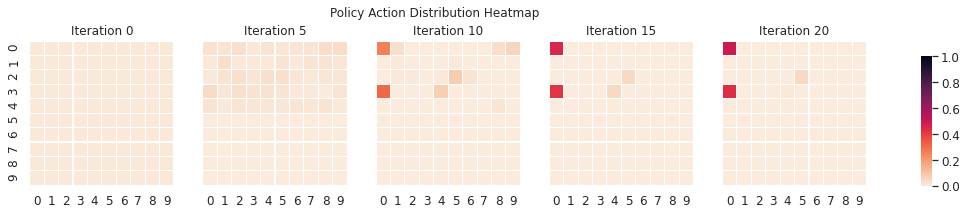

In [113]:
iters_to_plot = [0, 5, 10, 15, 20]
n_cols = len(iters_to_plot)
fig, axes = plt.subplots(1, n_cols, figsize=(3*n_cols, 3), sharex=True, sharey=True)
cbar_ax = fig.add_axes([.95, .15, .01, .6])
for j, i in enumerate(iters_to_plot):
    if i == iters_to_plot[-1]:
        plot_dist(filter_df(clip_data, iter=i).mean(axis=0), axes[j],
                  cbar=True, cbar_ax=cbar_ax)
    else:
        plot_dist(filter_df(clip_data, iter=i).mean(axis=0), axes[j])
    axes[j].set_title(f'Iteration {i}')
fig.suptitle('Policy Action Distribution Heatmap')
fig.subplots_adjust(top=0.85)
plt.show()

In [ ]:
noise_std = 0.3
noisy_reward_fn = functools.partial(reward_fn, noise_std=noise_std)
n_steps = 30
plot_freq = 6
n_actions_per_dim = 10
n_trials = 10

method_names = ['Flipped KL', 'Original KL', 'Clipping']
params_list = [flipped_kl_params, original_kl_params, clip_params]

n_cols = int(np.ceil(n_steps / plot_freq)) + 1

np.random.seed(0)

for _ in range(n_trials):
    fig, axes = plt.subplots(3, n_cols, figsize=(3*n_cols, 9), sharex=True, sharey=True)
    cbar_ax = fig.add_axes([.95, .2, .03, .6])

    kl_new_to_old = [[], [], []]
    kl_old_to_new = [[], [], []]
    for i, params in enumerate(params_list):
        policy = Discrete2DPolicy(n_actions_per_dim=n_actions_per_dim, init_probs=None)
        for j in range(n_steps):
            if j % plot_freq == 0:
                policy.plot(ax=axes[i][int(j/plot_freq)])
            _, kl_new_to_old_this_step, kl_old_to_new_this_step = ppo_step(
                policy, params, noisy_reward_fn, normalize_adv=False)
            kl_new_to_old[i].append(kl_new_to_old_this_step)
            kl_old_to_new[i].append(kl_old_to_new_this_step)
        # Share one colorbar for all subfigures.
        policy.plot(ax=axes[i][-1], colorbar_ax=cbar_ax if i == 0 else None)

    for i, name in enumerate(method_names):
        axes[i][0].set_ylabel(name, size='large')
    for j in range(0, n_steps+1, plot_freq):
        axes[0][int(j/plot_freq)].set_title('Step %d' % j)
    for row in axes:
        for ax in row:
            rect = patches.Rectangle((4,2),1,1,linewidth=1,edgecolor='#0E4D92',facecolor='none')
            ax.add_patch(rect)
            rect = patches.Rectangle((7,6),1,1,linewidth=1,edgecolor='#0E4D92',facecolor='none')
            ax.add_patch(rect)
    plt.show()